# Heartbeat Clacification

## **BUSSINESS UNDERSTANDING**

### Tujuan

Membangun sistem klasifikasi untuk deteksi kondisi jantung normal atau abnormal berdasarkan pola suara jantung. Agar sesorang yang kondisi jantungnya terdeteksi Abnormal akan diberi penanganan khusus

Membuat model dengan akurasi tinggi dan dapat mengenali pola suara jantung abnormal secara konsisten

## DATA UNDERSTANDING

  Dataset Heartbeat yang saya ambil dari Time Series Classification merupakan dataset time series multivariat yang berasal dari (web) yang sumbernya dari **PhysioNet/CinC Challenge 2016**.

  Rekaman suara jantung diperooleh dari beberapa kontributor di seluruh dunia, dikumpulkan di lingkungan klinis maupun non-klinis, dari subjek sehat maupun pasien patologis (sakit)

  Rekaman suara jantung dikumpulkan dari lokasi yang berbeda pada tubuh. Empat lokasi umumnya antara lain :

  - Area aurta
  - Area Triskupid (sekitar katup jantung)
  - Area pulmon (sekitar paru-paru)
  - Area mitral (Sekitar Salah satu katup jantung)

  Suara-suara tersebut dibagi menjadi Dua kelas yaitu **Abnormal** dengan 296 sample dan **Normal** dengan 113 sample. Rekaman normal berasal dari subyek yang sehat, sedangkan rekaman Abnormal berasal dari subyek dengan diagnosis jantung yang telah terkonfirmasi.

  - Komputer memotong suara per 0.061 detik untuk memecah suara menjadi frekuensi, agar suara katup yang cepat tidak terlewat.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install sktime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 8.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
from scipy.io import arff
import os

In [4]:
import os
import pandas as pd
from scipy.io import arff
from tabulate import tabulate


### Menampilkan Data

In [5]:
base_path = '/content/drive/MyDrive/PSD/Heartbeat'

train_file = os.path.join(base_path, 'Heartbeat_TRAIN.arff')
test_file  = os.path.join(base_path, 'Heartbeat_TEST.arff')


In [6]:
def load_arff_data(file_path, label_name="Data"):
    if not os.path.exists(file_path):
        print(f"⚠️ File tidak ditemukan: {file_path}")
        return None

    try:
        data, meta = arff.loadarff(file_path)
        df = pd.DataFrame(data)

        # Decode label dari bytes → string
        last_col = df.columns[-1]
        if df[last_col].dtype == object:
            df[last_col] = df[last_col].apply(
                lambda x: x.decode('utf-8') if isinstance(x, bytes) else x
            )

        print(f"✅ Berhasil memuat {label_name}: {df.shape} (Baris, Kolom)")
        return df

    except Exception as e:
        print(f"❌ Error membaca {label_name}: {e}")
        return None


In [7]:
print("\n--- LOADING DATA ---")
df_train = load_arff_data(train_file, "TRAIN (Data Latih)")
df_test  = load_arff_data(test_file,  "TEST (Data Uji)")



--- LOADING DATA ---
✅ Berhasil memuat TRAIN (Data Latih): (204, 2) (Baris, Kolom)
✅ Berhasil memuat TEST (Data Uji): (205, 2) (Baris, Kolom)


**5 data pertama**

- Menampilkan 61 Data Sinyal di tiap Id (sample).

- Menampilkan target (label)

In [10]:
from tabulate import tabulate
import numpy as np
import pandas as pd # Import pandas for concat

# Define df_all by concatenating df_train and df_test
df_all = pd.concat([df_train, df_test], ignore_index=True)

if df_all is not None:
    # --- BAGIAN YANG DIUBAH ---
    df_display = df_all.head(5).copy()

    print(f"\n--- Preview Dataset ({len(df_display)} Data Teratas) ---")

    # Tampilkan sebagian isi array (formatting agar rapi)
    if 'Heartbeat' in df_display.columns:
        df_display['Heartbeat'] = df_display['Heartbeat'].apply(
            lambda x: np.array2string(
                x[:10],               # ambil 10 angka pertama dalam array
                precision=6,
                separator=', ',
                suppress_small=True
            ) + '...'
            if isinstance(x, np.ndarray)
            else str(x)
        )

    print(tabulate(
        df_display,
        headers='keys',
        tablefmt='grid',
        showindex=True
    ))


--- Preview Dataset (5 Data Teratas) ---
+----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Distribusi kelas

Terdapat 147 sample abnormal di data training

terdapat 57 sample normal di data training

In [11]:
if df_train is not None:
    print("\n--- Distribusi Kelas Data TRAIN ---")

    class_dist = df_train.iloc[:, -1].value_counts().reset_index()
    class_dist.columns = ['Kelas', 'Jumlah']

    print(tabulate(
        class_dist,
        headers='keys',
        tablefmt='grid',
        showindex=False
    ))



--- Distribusi Kelas Data TRAIN ---
+----------+----------+
| Kelas    |   Jumlah |
+==========+==========+
| abnormal |      147 |
+----------+----------+
| normal   |       57 |
+----------+----------+


#### ringkasan dataset

Defaul split data dari web timeseriescluster adalah 50:50

In [12]:
summary_data = []

if df_train is not None:
    summary_data.append([
        'TRAIN',
        df_train.shape[0],
        df_train.shape[1],
        df_train.iloc[:, -1].nunique()
    ])

if df_test is not None:
    summary_data.append([
        'TEST',
        df_test.shape[0],
        df_test.shape[1],
        df_test.iloc[:, -1].nunique()
    ])

print("\n--- Ringkasan Dataset ---")
print(tabulate(
    summary_data,
    headers=['Dataset', 'Jumlah Data', 'Jumlah Kolom', 'Jumlah Kelas'],
    tablefmt='grid'
))



--- Ringkasan Dataset ---
+-----------+---------------+----------------+----------------+
| Dataset   |   Jumlah Data |   Jumlah Kolom |   Jumlah Kelas |
+===========+===============+================+================+
| TRAIN     |           204 |              2 |              2 |
+-----------+---------------+----------------+----------------+
| TEST      |           205 |              2 |              2 |
+-----------+---------------+----------------+----------------+


### Deteksi Missing Value

Jumlah Missing Value 0 sama dengan tidak adanya missing value

In [13]:
print("\n--- Missing Value di Level DataFrame ---")

missing_df = df_train.isnull().sum().reset_index()
missing_df.columns = ['Kolom', 'Jumlah Missing']

print(tabulate(
    missing_df,
    headers='keys',
    tablefmt='grid',
    showindex=False
))



--- Missing Value di Level DataFrame ---
+-----------+------------------+
| Kolom     |   Jumlah Missing |
+===========+==================+
| Heartbeat |                0 |
+-----------+------------------+
| target    |                0 |
+-----------+------------------+


### Menggabungkan Data

Digabungkan terlebih dahulu agar bisa di spil menjadi 80:20

In [14]:
from sklearn.model_selection import train_test_split
import pandas as pd

# ignore_index=True agar urutan nomor baris di-reset dari 0 sampai akhir
df_total = pd.concat([df_train, df_test], ignore_index=True)

print(f"Total data setelah digabung: {df_total.shape}")


Total data setelah digabung: (409, 2)


#### Cek Distribusi kelas

Distribusi kelas pada data total yaitu :

- 295 sample yang di label abnormal
- 114 sample yang di label normal

In [15]:
print(df_total.iloc[:, -1].value_counts())


target
abnormal    295
normal      114
Name: count, dtype: int64


### Deteksi Missing Value (Data Total)

Tidak ditemukan missing value pada data Total

In [16]:
rows_with_nan = df_total[
    (df_total.isnull().any(axis=1))
]

print("\n--- Baris yang Mengandung Missing Value ---")
print(rows_with_nan.shape)

if not rows_with_nan.empty:
    print(rows_with_nan.head())
else:
    print("✅ Tidak ditemukan missing value pada data.")


--- Baris yang Mengandung Missing Value ---
(0, 2)
✅ Tidak ditemukan missing value pada data.


### Deteksi Outlier di Data total

Dilakukan ekstraksi statistik karena Machine Learning tidak bisa membaca data 3 Dimensi, Machine learning butuh ekstraksi statistik untuk mendeteksi titik-titik angka yang tidak wajar (terlalu tinggi atau terlalu rendah) dibandingkan mayoritas data lainnya.

In [17]:
signal_col = 'Heartbeat'

# Ensure the column exists and contains structured arrays
if signal_col not in df_total.columns:
    raise ValueError(f"Column '{signal_col}' not found in df_total.")

# Convert each structured array (numpy.void) to a 1D float array
# Then concatenate all these 1D arrays into one large 1D array of floats
all_values_numeric = np.concatenate([arr.view(np.float64).reshape(-1) for arr in df_total[signal_col].values])

Q1 = np.percentile(all_values_numeric, 25)
Q3 = np.percentile(all_values_numeric, 75)
IQR = Q3 - Q1

outlier_points = all_values_numeric[
    (all_values_numeric < Q1 - 1.5*IQR) |
    (all_values_numeric > Q3 + 1.5*IQR)
]

print("Jumlah titik ekstrem:", len(outlier_points))

Jumlah titik ekstrem: 1696836


#### Tandai Outlier

Berdasarkan rata-rata, data yang terdeteksi Outlier ada 26, **Namun** tidak diwajibkan menghapus outlier karena Outlier dalam data kesehatan bisa jadi adalah penyakit itu sendiri

In [18]:
import numpy as np
import pandas as pd

# Define signal_col if not already defined globally, assuming it's 'Heartbeat'
signal_col = 'Heartbeat'

# Helper function to extract statistics from structured NumPy arrays
def extract_stats_for_outlier_check(structured_array):
    if isinstance(structured_array, np.ndarray) and structured_array.dtype.fields is not None:
        # Convert structured array to a 1D float array
        float_array = structured_array.view(np.float64).reshape(-1)
    else:
        # Handle cases where it might already be a plain array or list
        float_array = np.asarray(structured_array, dtype=float)

    return pd.Series({
        'mean': np.mean(float_array),

    })

# Apply the function to the 'Heartbeat' column and combine with the target label
stats_df = df_total[signal_col].apply(extract_stats_for_outlier_check)
df_outlier_check = pd.concat([stats_df, df_total.iloc[:, -1].rename('label')], axis=1)

# Now proceed with the original logic of the cell to detect outliers
Q1 = df_outlier_check['mean'].quantile(0.25)
Q3 = df_outlier_check['mean'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outlier_candidates = df_outlier_check[
    (df_outlier_check['mean'] < lower_bound) |
    (df_outlier_check['mean'] > upper_bound)
]

print("\n--- Kandidat Outlier berdasarkan MEAN ---")
print(f"Jumlah kandidat outlier: {len(outlier_candidates)}")


--- Kandidat Outlier berdasarkan MEAN ---
Jumlah kandidat outlier: 26


#### Visualisas Outlier

Sumbu X Menandakan Id (sample) 1 sampai 409

Sumbu Menandakan Kekerasan suara (Amplitudo). Makin ke atas, makin "berisik" jantungnya.

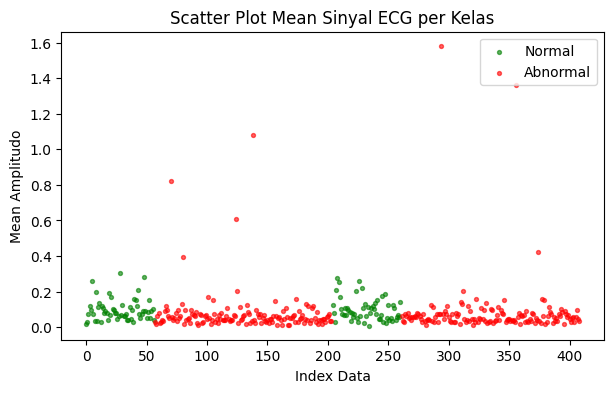

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))

# Plot per kelas
for label, color in zip(
    ['normal', 'abnormal'],
    ['green', 'red']
):
    subset = df_outlier_check[df_outlier_check['label'] == label]

    plt.scatter(
        subset.index,
        subset['mean'],
        s=8,
        alpha=0.6,
        label=label.capitalize(),
        color=color
    )

plt.title("Scatter Plot Mean Sinyal ECG per Kelas")
plt.xlabel("Index Data")
plt.ylabel("Mean Amplitudo")
plt.legend()
plt.show()


## **DATA PREPROCESSING**

### SPLIT DATA (80:20)

Karena titik ini paling sering dipakai karena dianggap sebagai "titik keseimbangan terbaik".

Distribusi kelas pada data total yaitu :

327 sample yang di label abnormal
82 sample yang di label normal

In [21]:
X = df_total.iloc[:, :-1]
y = df_total.iloc[:, -1]

X_train_baru, X_test_baru, y_train_baru, y_test_baru = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [22]:
# (Opsional) Gabungkan kembali X dan y jika ingin melihat dalam bentuk tabel utuh
df_train_80 = pd.concat([X_train_baru, y_train_baru], axis=1)
df_test_20 = pd.concat([X_test_baru, y_test_baru], axis=1)

# 4. CEK HASILNYA
print("\n--- Hasil Pembagian Baru (80:20) ---")
print(f"Data Latih (80%): {df_train_80.shape}")
print(f"Data Uji   (20%): {df_test_20.shape}")

print("\nSebaran kelas di Data Latih baru:")
print(y_train_baru.value_counts())


--- Hasil Pembagian Baru (80:20) ---
Data Latih (80%): (327, 2)
Data Uji   (20%): (82, 2)

Sebaran kelas di Data Latih baru:
target
abnormal    236
normal       91
Name: count, dtype: int64


VIsualisasi :

- Garis Biru (Normal): Detak jantung orang sehat itu konsisten dan kuat.

- Garis Oranye (Abnormal): Lebih rendah dan datar. Ini terjadi karena detak jantung orang sakit itu tidak beraturan (kacau)

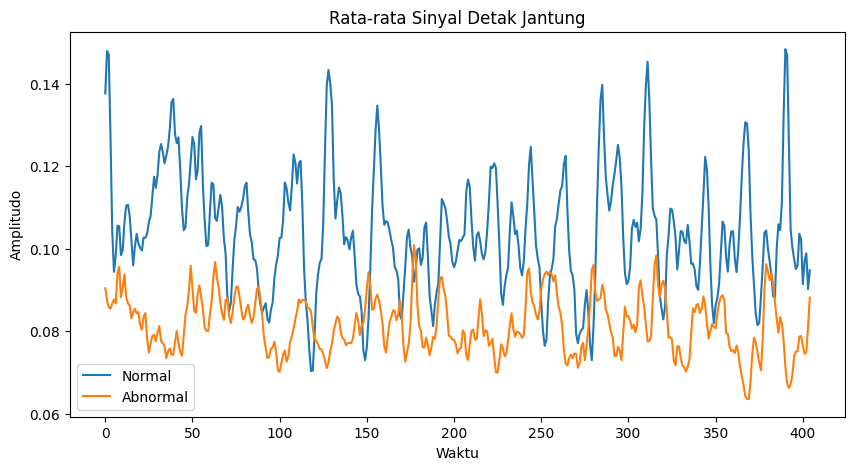

In [23]:
import numpy as np
import matplotlib.pyplot as plt

label_col = df_train_80.columns[-1]

# pastikan label string
if isinstance(df_train_80.iloc[0][label_col], bytes):
    df_train_80[label_col] = df_train_80[label_col].str.decode('utf-8')

# Helper function to convert structured NumPy arrays to plain float arrays
def convert_structured_to_float_array(structured_array):
    if isinstance(structured_array, np.ndarray) and structured_array.dtype.fields is not None:
        # Assuming all fields are float and we want to flatten them into a 2D array
        # Get the base type of the first field (e.g., np.float64)
        base_dtype = structured_array.dtype[0].base
        # View as a flat array of the base type, then reshape to 2D (num_timesteps, num_features)
        return structured_array.view(base_dtype).reshape(structured_array.shape[0], -1)
    else:
        # If it's already a regular numpy array or list of lists, convert to float array
        return np.asarray(structured_array, dtype=float)

# Ambil semua sinyal dan konversi ke array float standar
normal_signals_converted = df_train_80[df_train_80[label_col]=='normal'].iloc[:, 0].apply(convert_structured_to_float_array)
abnormal_signals_converted = df_train_80[df_train_80[label_col]=='abnormal'].iloc[:, 0].apply(convert_structured_to_float_array)

# Stack the converted signals
normal_signals = np.vstack(normal_signals_converted.tolist())
abnormal_signals = np.vstack(abnormal_signals_converted.tolist())

# Hitung rata-rata
mean_normal = normal_signals.mean(axis=0)
mean_abnormal = abnormal_signals.mean(axis=0)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(mean_normal, label='Normal')
plt.plot(mean_abnormal, label='Abnormal')
plt.title("Rata-rata Sinyal Detak Jantung")
plt.xlabel("Waktu")
plt.ylabel("Amplitudo")
plt.legend()
plt.show()


### Encoding label

Sebelum di encoder

In [53]:
print("Label train:")
print(y_train_baru.value_counts())

print("\nLabel test:")
print(y_test_baru.value_counts())


Label train:
target
abnormal    236
normal       91
Name: count, dtype: int64

Label test:
target
abnormal    59
normal      23
Name: count, dtype: int64


Sesudah di encoder

In [56]:
label_mapping = {
    'normal': 0,
    'abnormal': 1
}

y_train_enc = y_train_baru.map(label_mapping)
y_test_enc  = y_test_baru.map(label_mapping)

# Cek hasil
print("\nEncoding label (TRAIN):")
print(y_train_enc.value_counts())

print("\nEncoding label (TEST):")
print(y_test_enc.value_counts())


Encoding label (TRAIN):
target
1    236
0     91
Name: count, dtype: int64

Encoding label (TEST):
target
1    59
0    23
Name: count, dtype: int64


Gunanya Label encoder adalah untuk memudahkan Machine Learning membaca Label, karena sebelumnya memakai String, maka diubah menjadi tipe data numerik

Label 0 adalah Normal
Label 1 adalah Abnormal

### Normalisasi (Opsional)

In [84]:
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()

# Helper function to convert structured NumPy arrays to plain float arrays
def convert_structured_to_plain_float_array(structured_array):
    if isinstance(structured_array, np.ndarray) and structured_array.dtype.fields is not None:
        return structured_array.view(np.float64).reshape(-1)
    else:
        return np.asarray(structured_array, dtype=float)

# Apply this conversion to X_train_baru and X_test_baru to get 2D arrays
X_train_processed_scaled = np.vstack(X_train_baru['Heartbeat'].apply(convert_structured_to_plain_float_array).tolist())
X_test_processed_scaled = np.vstack(X_test_baru['Heartbeat'].apply(convert_structured_to_plain_float_array).tolist())

# FIT hanya di data TRAIN (WAJIB)
X_train_norm = scaler.fit_transform(X_train_processed_scaled)

# TRANSFORM data TEST
X_test_norm = scaler.transform(X_test_processed_scaled)

print("Train (norm):", X_train_norm.shape)
print("Test  (norm):", X_test_norm.shape)

Train (norm): (327, 24705)
Test  (norm): (82, 24705)


## Modelling

In [81]:
# X_train_baru dan X_test_baru TANPA normalisasi
X_train_raw = X_train_baru.copy()
X_test_raw  = X_test_baru.copy()

y_train = y_train_enc
y_test  = y_test_enc

print("Train:", X_train_raw.shape)
print("Test :", X_test_raw.shape)


Train: (327, 1)
Test : (82, 1)


### Modelling menggunakan Random forest

In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Helper function to convert structured NumPy arrays to plain float arrays
def convert_structured_to_plain_float_array(structured_array):
    if isinstance(structured_array, np.ndarray) and structured_array.dtype.fields is not None:
        return structured_array.view(np.float64).reshape(-1)
    else:
        return np.asarray(structured_array, dtype=float)

# Apply this conversion to X_train_baru and X_test_baru
X_train_rf_processed = np.vstack(X_train_baru['Heartbeat'].apply(convert_structured_to_plain_float_array).tolist())
X_test_rf_processed = np.vstack(X_test_baru['Heartbeat'].apply(convert_structured_to_plain_float_array).tolist())

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    class_weight='balanced'  # penting karena data imbalance
)

rf.fit(X_train_rf_processed, y_train_enc)

y_pred_rf = rf.predict(X_test_rf_processed)

print("Accuracy Random Forest:", accuracy_score(y_test_enc, y_pred_rf))
print("\nClassification Report Random Forest:")
print(classification_report(y_test_enc, y_pred_rf))

Accuracy Random Forest: 0.7560975609756098

Classification Report Random Forest:
              precision    recall  f1-score   support

           0       1.00      0.13      0.23        23
           1       0.75      1.00      0.86        59

    accuracy                           0.76        82
   macro avg       0.87      0.57      0.54        82
weighted avg       0.82      0.76      0.68        82



## Evaluasi

Evaluasi ini membuktikan bahwa Random Forest Anda tidak hanya "asal tebak", tapi memiliki pola logika yang jelas (dilihat dari Feature Importance) dan performanya bisa diukur secara objektif medis (dilihat dari Recall & ROC).

## **DEPLOYMENT**

In [95]:
# Ambil satu sampel data test (misal baris ke-0)
# Pastikan X_test_processed_scaled atau variabel data siap pakai Anda ada
sample_data = X_test_processed_scaled[0]

# Simpan ke CSV
import numpy as np
np.savetxt("contoh_sinyal_jantung.csv", sample_data.reshape(1, -1), delimiter=",")

print("File 'contoh_sinyal_jantung.csv' berhasil dibuat! Download file ini untuk tes di Streamlit.")

File 'contoh_sinyal_jantung.csv' berhasil dibuat! Download file ini untuk tes di Streamlit.


## Link Deployment